# Plotting the Gadget Simulation results


In [5]:
%matplotlib inline

from __future__ import division

from pygadgetreader import *

import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from tqdm import tqdm
import sys

#----- MATPLOTLIB paramaters ---------
mpl.rcParams.update({'font.size': 18,'font.family':'serif'})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.right'] = True
mpl.rc('text', usetex=True)
#--------------------------------------

from scipy.interpolate import interp1d
from scipy.integrate import quad


### Some constants and parameters


In [6]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2

simID = "M30_a0.01_lo_bin_e0.95_full"

title_text = r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.95$"

Nframes = 2001

rootdir = "sims/" + simID + "/out/"

print "Loading output from folder: ", rootdir

M_PBH =readsnap(rootdir+"snapshot_000", "mass", 1, suppress=1)[0]

Loading output from folder:  sims/M30_a0.01_lo_bin_e0.95_full/out/


In [7]:
#Read in the first header file
part_string = ["dmcount", "diskcount","bulgecount", "starcount","bndrycount"]

nParticles = np.zeros(5, dtype='int')
for i in range(5):
    nParticles[i] = readheader(rootdir+"snapshot_000", part_string[i])

nPBH = nParticles[0]
nDM = nParticles[1:]
print "   Number of PBHs:", nPBH
print "   Number of DM particles:", nDM

mDM = np.zeros(4)
for i in range(4):
    #print nDM[i]
    if (nDM[i] > 0):
        #print readsnap(rootdir+"snapshot_000", "mass", i+2, suppress=1)[0]
        mDM[i] = readsnap(rootdir+"snapshot_000", "mass", i+2, suppress=1)[0]

print "   DM particle masses:", mDM

r_tr = 1.0
aPBH = 1.0

scaling = 1e-5


   Number of PBHs: 2
   Number of DM particles: [18080     0     0     0]
   DM particle masses: [ 0.00034321  0.          0.          0.        ]


### Functions for reading in and calculating simulation properties

In [8]:
def GetPBHsep(i):
    id = format(i, '03d')
    xPBH = readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    deltax = xPBH[0,:] - xPBH[1,:]
    return scaling*np.sqrt(np.sum(deltax**2))

def GetDMr(i):
    id = format(i, '03d')
    #print "   Snapshot", id
    xPBH = readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    #xPBH = 0.0
    pid = readsnap(rootdir+"snapshot_" + str(id), "pid", 1, suppress=1)
    
    i1 = [0,1]
    if (pid[0] > pid[1]):
        i1 = [1,0]

    if (nPBH > 1):
        xPBH = 1.0*xPBH[i1[0],:]
    xDM = readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    rDM = np.sqrt(np.sum((xDM - xPBH)**2.0, axis=1))
    #print np.min(rDM*scaling)
    return scaling*rDM

#DM mass inside 0.1 r_tr (for 30 M_solar)
def GetDMenc(fid):
    return mDM[0]*np.sum(GetDMr(fid) < 4.33e-04)

def GetL_PBH(fid):
    id = format(fid, '03d')
    xPBH = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    #print xPBH
    vPBH = readsnap(rootdir+"snapshot_" + str(id), "vel", 1, suppress=1)
    #print vPBH
    L_PBH = np.cross(xPBH, vPBH)
    #print L_PBH
    return M_PBH*np.sum(L_PBH, axis=0)
    #return M_PBH*L_PBH[0,:]

def Getv_PBH(fid):
    id = format(fid, '03d')
    vPBH = readsnap(rootdir+"snapshot_" + str(id), "vel", 1, suppress=1)
    return vPBH[0,:] - vPBH[1,:]

def Getr_PBH(fid):
    id = format(fid, '03d')
    xPBH = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    return xPBH[0,:] - xPBH[1,:]

def GetL_DM(fid):
    id = format(fid, '03d')
    xDM = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    vDM = readsnap(rootdir+"snapshot_" + str(id), "vel", 2, suppress=1)
    L_DM = np.cross(xDM, vDM)
    return mDM[0]*np.sum(L_DM, axis=0)

def Getv_DM(fid):
    id = format(fid, '03d')
    #xDM = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    vDM = readsnap(rootdir+"snapshot_" + str(id), "vel", 2, suppress=1)
    #L_DM = np.cross(xDM, vDM)
    return np.mean(vDM, axis=0)
    

#### Get times of each snapshot

In [9]:
dt = 9.785e-3 #kyr 

def GetSimTime(fid):
    id = format(fid, '03d')
    t = readheader(rootdir+"snapshot_" + id, "time")
    return t

tlist = np.zeros(Nframes)
for i in tqdm(range(Nframes)):
    tlist[i] = GetSimTime(i)
    
tvals = tlist*dt

100%|██████████| 2001/2001 [00:01<00:00, 1745.49it/s]


#### Calculating + plotting PBH separation and DM mass enclosed

In [10]:
sep = np.zeros(Nframes)
DMmass = np.zeros(Nframes)

for i in tqdm(range(Nframes)):

    sep[i] = GetPBHsep(i)
    DMmass[i] = GetDMenc(i)

100%|██████████| 2001/2001 [00:10<00:00, 187.24it/s]


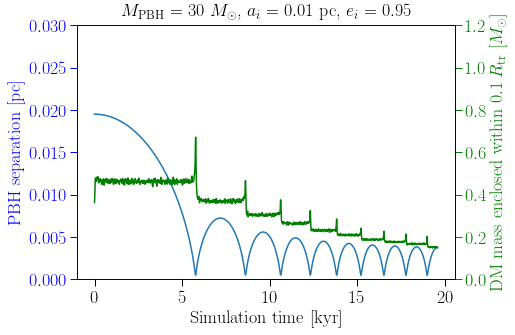

In [11]:
fig, ax1 = pl.subplots(figsize=(7.5,5))
                                  
ax1.plot(tvals,sep)

#ax1.set_ylim(1e-5, 1e0)
ax1.set_ylim(0, 3e-2)
#ax1.fill_between(tvals, 1e-3, 1e-2, color='grey', alpha=0.25)
ax1.set_xlabel(r"Simulation time [kyr]")
#ax1.set_title(sys.argv[1])
ax1.set_title(title_text, fontsize=18.0)
ax1.tick_params('y', colors='b')
ax1.set_ylabel(r"PBH separation [pc]", color='b')

ax2 = ax1.twinx()
ax2.plot(tvals,DMmass, 'g')
ax2.tick_params('y', colors='g')
ax2.set_ylabel(r'DM mass enclosed within $0.1\,R_\mathrm{tr}$ [$M_\odot$]', color='g')
ax2.set_ylim(0, 1.2)
pl.tight_layout()
pl.savefig("../plots/PBH_separation_" + simID + ".pdf", bbox_inches='tight')

#### Calculating and plotting angular momenta

In [12]:
LPBH = np.zeros((Nframes, 3))
LDM = np.zeros((Nframes, 3))

vPBH = np.zeros((Nframes,3))
rPBH = np.zeros((Nframes,3))

vDM = np.zeros((Nframes,3))

for i in tqdm(range(Nframes)):

    vPBH[i,:] = Getv_PBH(i)
    vDM[i,:] = Getv_DM(i)
    rPBH[i,:] = Getr_PBH(i)
    LPBH[i,:] = GetL_PBH(i)
    LDM[i,:] = GetL_DM(i)

100%|██████████| 2001/2001 [00:15<00:00, 133.12it/s]


[  5.76336494   8.61079995  10.62650996  12.31931496  13.81641993
  15.20588998  16.51707994  17.76956     18.98289998]


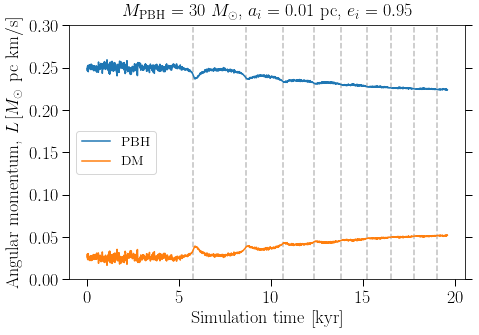

In [15]:
LPBH_mag = np.sqrt(np.sum(LPBH**2, 1))
LDM_mag = np.sqrt(np.sum(LDM**2, 1))

pl.figure(figsize=(7,5))

sep_cut = sep[550:]

t_cp_list = tvals[550:][np.r_[True, sep_cut[1:] < sep_cut[:-1]] & np.r_[sep_cut[:-1] < sep_cut[1:], True]]
print t_cp_list
#Calculate when the first close passage happens
#t_cp = tvals[np.argmin(sep[:600])]
#print(t_cp)
for t_cp in t_cp_list:
    pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)
#pl.axvline(6.0, linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, LPBH_mag, label='PBH')
pl.plot(tvals, LDM_mag, label='DM')

pl.legend(loc='best', fontsize=14.0)
pl.title(title_text, fontsize=18.0)
pl.xlabel(r"Simulation time [kyr]")
pl.ylabel(r"Angular momentum, $L \,[M_\odot\,\,\mathrm{pc}\,\,\mathrm{km/s}]$")
pl.ylim(0, 0.3)
pl.tight_layout()
pl.savefig("../plots/PBH_L_" + simID + ".pdf", bbox_inches='tight')

In [ ]:


pl.figure(figsize=(7,5))

#Calculate when the first close passage happens
t_cp = tvals[np.argmin(sep[:600])]
print(t_cp)
pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)

pl.semilogy(tvals, np.sqrt(np.sum(vPBH**2,axis=1)), label='PBH')

pl.legend(loc='best')
pl.title(title_text, fontsize=14.0)
pl.xlabel(r"Simulation time [kyr]")
pl.ylabel(r"$v [\mathrm{km/s}]$")
#pl.ylim(0, 0.1)
pl.xlim(0, 10.0)
pl.tight_layout()
#pl.savefig("../plots/PBH_L_" + simID + ".pdf")


pl.figure(figsize=(7,5))

#Calculate when the first close passage happens
t_cp = tvals[np.argmin(sep[:600])]
print(t_cp)
pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)
pl.axhline(np.sqrt(np.sum(vPBH[0,:]**2)),linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, np.sqrt(np.sum(vPBH**2,axis=1)) - 0.0*2.0*G_N*30.0/sep, label='PBH')

pl.legend(loc='best')
pl.title(r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.995$", fontsize=14.0)
pl.xlabel(r"Simulation time [kyr]")
#pl.ylabel(r"$v [\mathrm{km/s}]$")
#pl.ylim(0, 1e3)
pl.xlim(5.7, 6.0)
pl.tight_layout()
#pl.savefig("../plots/PBH_L_" + simID + ".pdf")

In [ ]:
pl.figure(figsize=(7,5))

#Calculate when the first close passage happens
t_cp = tvals[np.argmin(sep[:600])]

#pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, np.sqrt(np.sum(rPBH**2,axis=1)) - 0.0*2.0*G_N*30.0/sep, color='r', label='r')

ax1 = pl.gca()
ax2 = ax1.twinx()
ax2.plot(tvals, np.sqrt(np.sum(vPBH**2,axis=1)) - 0.0*2.0*G_N*30.0/sep, color='b', label='v')

pl.legend(loc='best')
pl.title(r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.995$", fontsize=14.0)
pl.xlabel(r"Simulation time [kyr]")
#pl.ylabel(r"$v [\mathrm{km/s}]$")
#pl.ylim(0, 1e3)
#pl.xlim(5.7, 6.0)
pl.tight_layout()
#pl.savefig("../plots/PBH_L_" + simID + ".pdf")

In [ ]:
pl.figure(figsize=(7,5))

#Calculate when the first close passage happens
t_cp = tvals[np.argmin(sep[:600])]

#pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, np.cross(rPBH,vPBH) , color='r', label='r')

ax1 = pl.gca()
ax2 = ax1.twinx()
ax2.plot(tvals, vPBH[:,0], color='b', label='v')

pl.legend(loc='best')
pl.title(r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.995$", fontsize=14.0)
pl.xlabel(r"Simulation time [kyr]")
#pl.ylabel(r"$v [\mathrm{km/s}]$")
#pl.ylim(0, 1e3)
#pl.xlim(5.7, 6.0)
pl.tight_layout()
#pl.savefig("../plots/PBH_L_" + simID + ".pdf")

In [ ]:
pl.figure(figsize=(7,5))

#Calculate when the first close passage happens
t_cp = tvals[np.argmin(sep[:600])]

pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, vDM[:,0], alpha=0.3, label='x')
pl.plot(tvals, vDM[:,1], alpha=0.3, label='y')
pl.plot(tvals, vDM[:,2], alpha=0.3, label='z')

pl.legend(loc='best')
pl.title(r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.995$", fontsize=14.0)
pl.xlabel(r"Simulation time [kyr]")
#pl.ylabel(r"$v [\mathrm{km/s}]$")
#pl.ylim(0, 1e3)
#pl.xlim(5.7, 6.0)
pl.tight_layout()
#pl.savefig("../plots/PBH_L_" + simID + ".pdf")

In [ ]:
def GetLDMlist(fid):

    id = format(fid, '03d')
    xDM = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    vDM = readsnap(rootdir+"snapshot_" + str(id), "vel", 2, suppress=1)
    L_DM = np.cross(xDM, vDM)
    return L_DM[:,2]

print np.sum(GetLDMlist(2000))

pl.figure()
pl.hist(GetLDMlist(0), bins=np.linspace(-0.5,0.5,51), alpha=0.25, label='0')
pl.hist(GetLDMlist(2000), bins=np.linspace(-0.5,0.5,51), alpha=0.25, label='later')
pl.legend(loc='best')
pl.show()

In [ ]:
print(2*np.pi*np.sqrt((1e-6)**3/(G_N*30.0)))